## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import datetime
now = datetime.datetime.now()
print("\n\nCurrent date:", now)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16833463362906106961
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7119215002
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16747151447706791195
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


Current date: 2019-10-08 16:58:02.991760


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from scipy.signal import medfilt
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator import data_generator_head, get_XY_head
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNGRU, CuDNNLSTM, Conv1D, MaxPooling1D, Lambda, LSTM
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Jul 10 2019, 11:58:48) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


### Set lookback and delay for prediction

In [3]:
experiment_name = 'final_FFN_LSTM_interleaved'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)


# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

### Create and compile model

In [4]:
K.clear_session()

layers = [3, 9, len_delay*3]

# create model
input_x = Input(shape=(n_lookback, 1))
input_y = Input(shape=(n_lookback, 1))
input_z = Input(shape=(n_lookback, 1))

conv_x = Conv1D(1,10, padding='same')(input_x)
conv_y = Conv1D(1,10, padding='same')(input_y)
conv_z = Conv1D(1,10, padding='same')(input_z)

input_ = Concatenate()([conv_x,conv_y,conv_z])

initialLSTMOut = CuDNNLSTM(layers[1], return_sequences=True)(input_)
firstDenseIn = Concatenate()([input_,initialLSTMOut])
firstDenseOut = Dense(layers[1], activation='relu')(firstDenseIn)

firstLSTMIn = Concatenate()([firstDenseOut,initialLSTMOut])
firstLSTMOut = CuDNNLSTM(layers[1], return_sequences=True)(firstLSTMIn)

secondDenseIn = Concatenate()([firstDenseOut,firstLSTMOut])
#secondDenseIn = Dropout(0.01)(secondDenseIn)
secondDenseOut = Dense(layers[1], activation='relu')(secondDenseIn)

secondLSTMIn = Concatenate()([secondDenseOut,firstLSTMOut])
#secondLSTMIn = Dropout(0.01)(secondLSTMIn)
secondLSTMOut = CuDNNLSTM(layers[1], return_sequences=True)(secondLSTMIn)

thirdDenseIn = Concatenate()([secondDenseOut,secondLSTMOut])
#thirdDenseIn = Dropout(0.01)(thirdDenseIn)
thirdDenseOut = Dense(layers[1], activation='relu')(thirdDenseIn)

thirdLSTMIn = Concatenate()([thirdDenseOut,secondLSTMOut])
#thirdLSTMIn = Dropout(0.01)(thirdLSTMIn)
thirdLSTMOut = CuDNNLSTM(layers[1], return_sequences=True)(thirdLSTMIn)

fourthDenseIn = Concatenate()([thirdDenseOut,thirdLSTMOut])
#fourthDenseIn = Dropout(0.01)(fourthDenseIn)
fourthDenseOut = Dense(layers[1], activation='relu')(fourthDenseIn)

fourthLSTMIn = Concatenate()([fourthDenseOut,thirdLSTMOut])
#fourthLSTMIn = Dropout(0.01)(fourthLSTMIn)
fourthLSTMOut = CuDNNLSTM(layers[1], return_sequences=False)(fourthLSTMIn)

#outputDenseIn = Concatenate()([fourthDenseOut,fourthLSTMOut])
#outputDenseIn = Dropout(0.01)(outputDenseIn)
output = Dense(layers[2])(fourthLSTMOut)
model = Model(inputs=[input_x, input_y, input_z],outputs=output)

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss="mae", optimizer='adam', metrics=[rmse])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25, 1)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 25, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 25, 1)        11          input_1[0][0]                    
____________________________________________________________________________________________

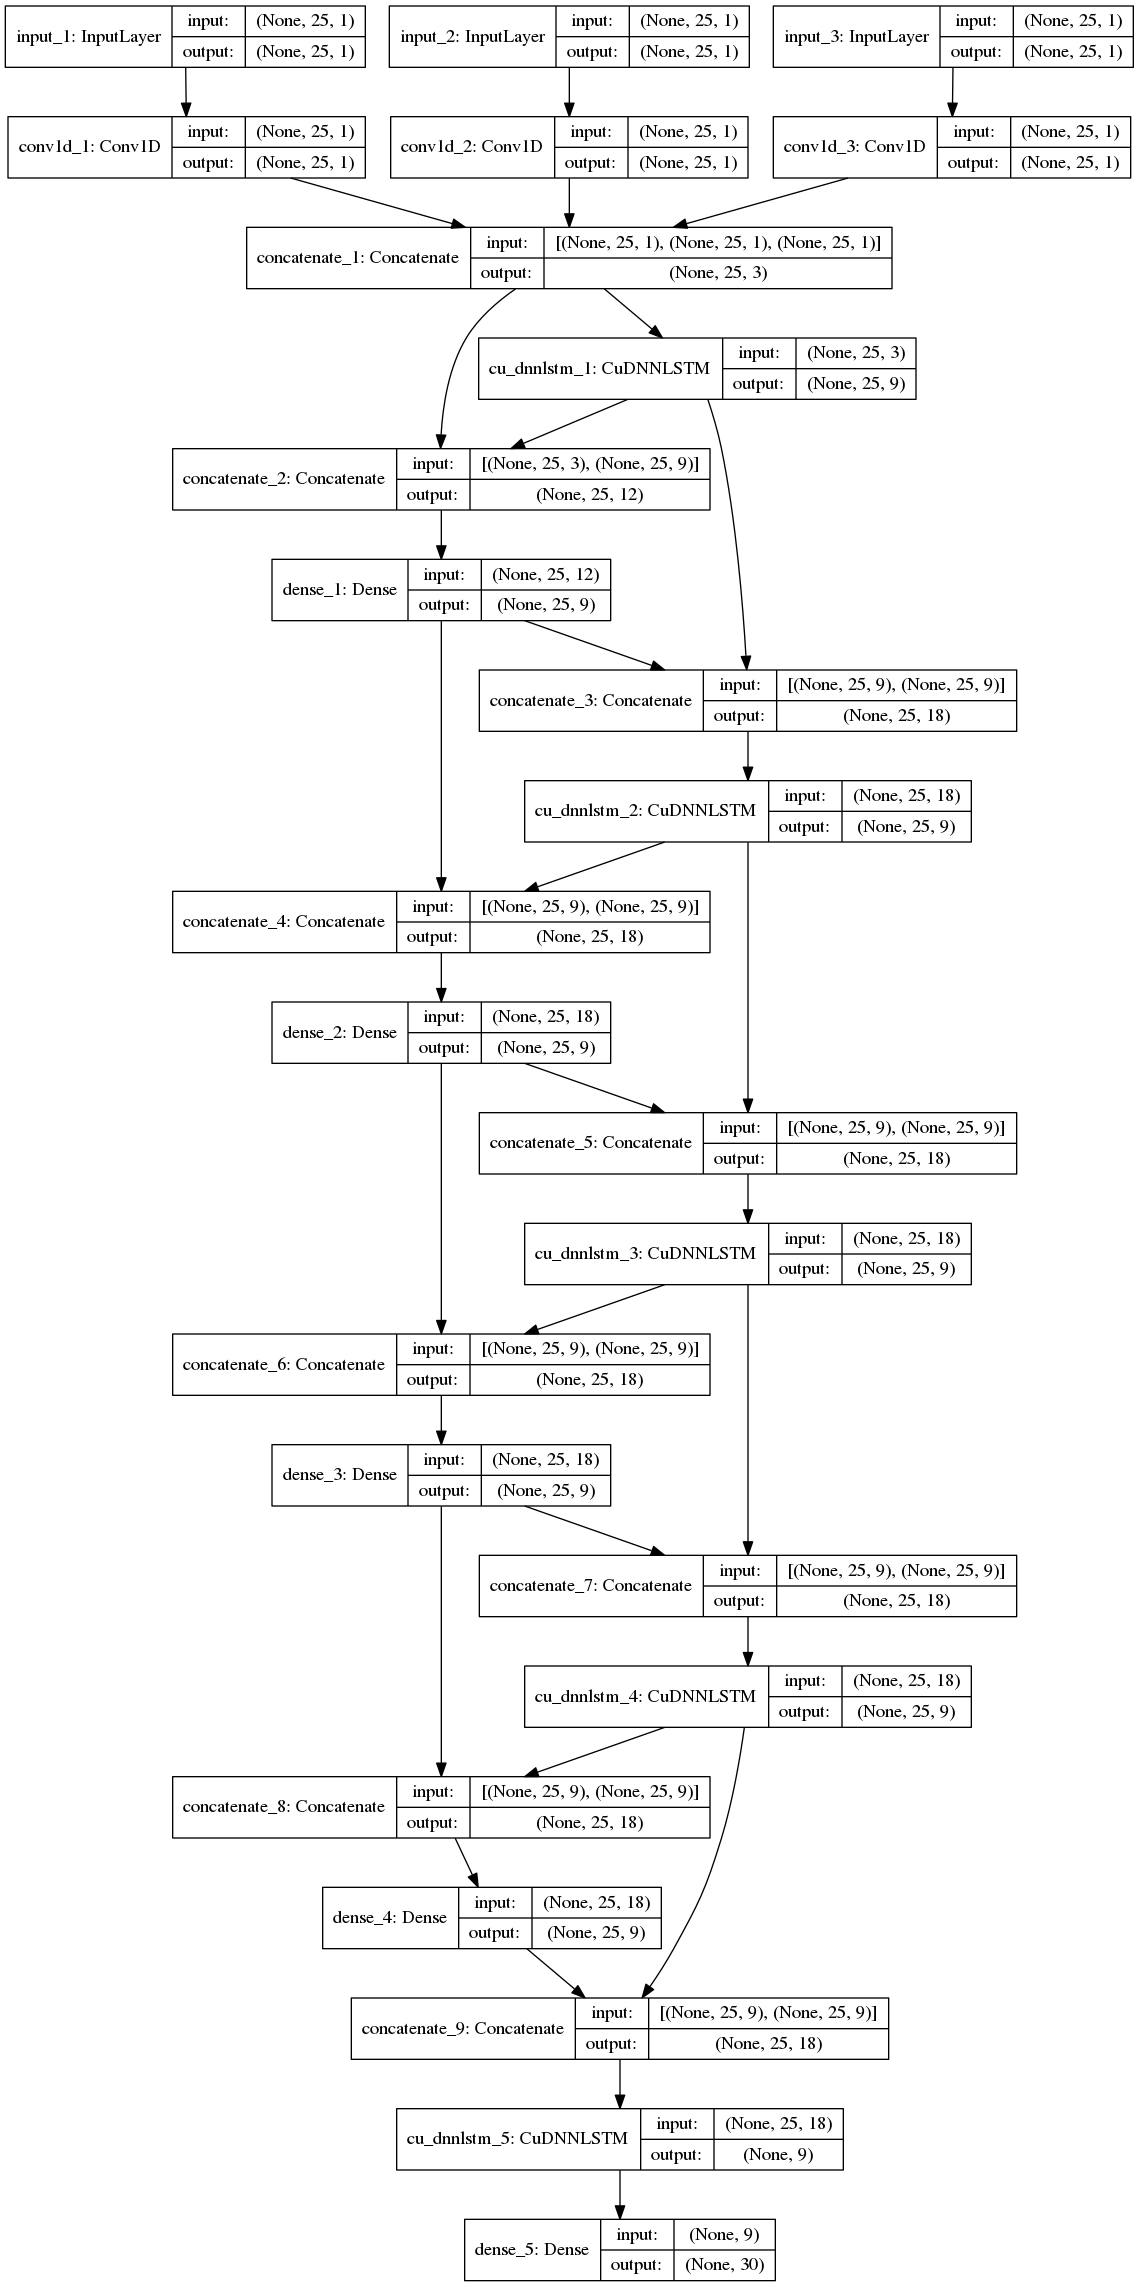

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

### Define callbacks

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
# Read preprocessed files

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
file_names = os.listdir(path_to_sensor_data_train)

In [8]:
nb_epochs = 150

perc_train = 0.8
ind_max_train = int(np.round(len(file_names) * perc_train))
file_names_train = file_names[:ind_max_train]
file_names_val = file_names[ind_max_train:]

train_gen = data_generator_head(path_to_sensor_data_train,
                                file_names_train,
                                delays_list,
                                n_max_delay,
                                n_lookback,
                                n_delay)

val_gen = data_generator_head(path_to_sensor_data_train,
                              file_names_val,
                              delays_list,
                              n_max_delay,
                              n_lookback,
                              n_delay)

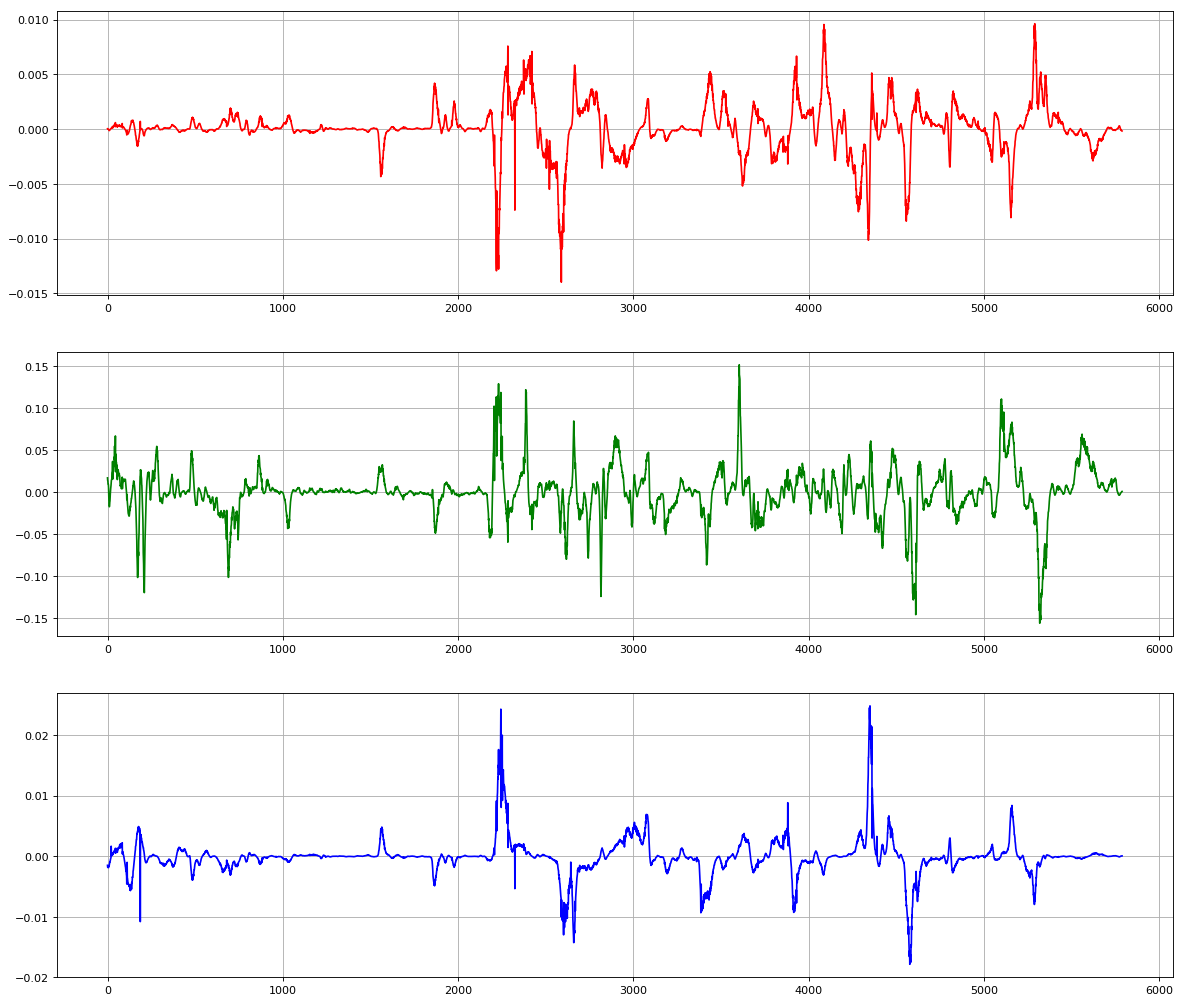

In [9]:
[X_x, X_y, X_z], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(X_x[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(X_y[:,0,0], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(X_z[:,0,0], c='b')
plt.grid(True)

Text(0.5, 0, 'time (in ms)')

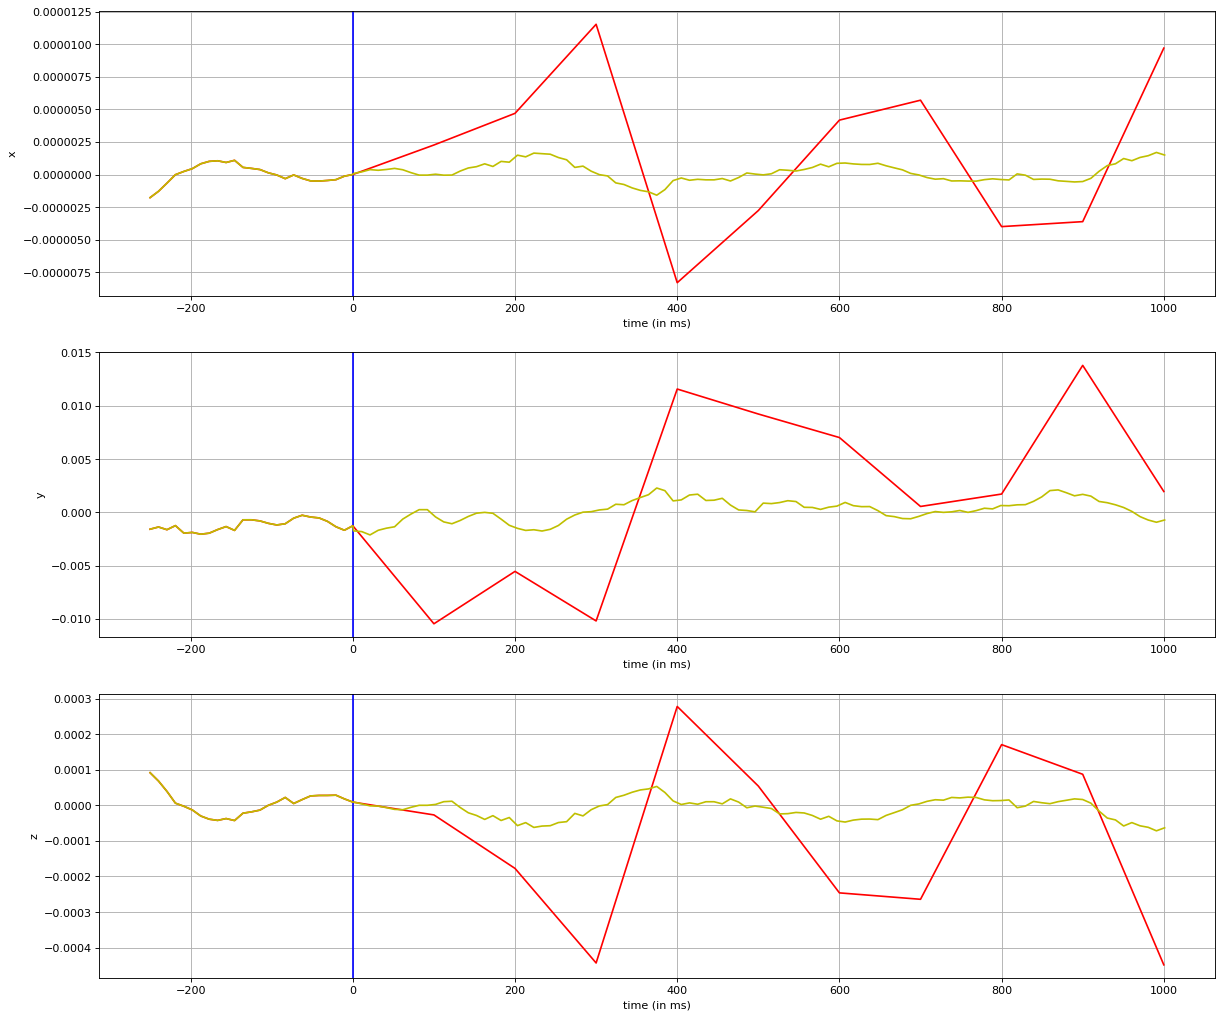

In [10]:
[X_x, X_y, X_z], Y_train = next(train_gen)
#print(np.amax(Y))
#print(X_x.shape, Y_train.shape)
#Y_pred = model.predict([X_x, X_y, X_z, X_sal_maps], verbose=0)
fig=plt.figure(figsize=(18, 16), dpi= 80)

#plt.subplot(131)
x_axis_truth = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(1, delays_list[-1]+1, num=step_delay)))
x_axis = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(100, 1000, num=len_delay)))
time_sample = 300
plt.subplot(311)
plt.axvline(x=0, c="b")
plt.grid(True)
# Plot X (input) and Y (ground truth) of x coordinate
plt.plot(x_axis, np.concatenate((X_x[time_sample,:,0], Y_train[time_sample, 0:10])),label='Differences 100ms', c='r')
# Plot X (input) and real values of X_x in the future
plt.plot(x_axis_truth, np.concatenate((X_x[time_sample,:,0], X_x[time_sample+n_lookback:time_sample+n_lookback+100,0, 0])), c='y')
#plt.plot(x_axis, np.concatenate((X_x[time_sample,:,0,0], Y_pred[time_sample, 0:10])),label='X_val x', c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")

plt.subplot(312)
plt.axvline(x=0, c="b")
plt.grid(True)
plt.plot(x_axis, np.concatenate((X_y[time_sample,:,0], Y_train[time_sample, 10:20])),label='X_val x', c='r')
plt.plot(x_axis_truth, np.concatenate((X_y[time_sample,:,0], X_y[time_sample+n_lookback:time_sample+n_lookback+100,0, 0])), c='y')

#plt.plot(x_axis, np.concatenate((X_y[time_sample,:,0,0], Y_pred[time_sample, 10:20])),label='X_val x', c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")

plt.subplot(313)
plt.axvline(x=0, c="b")
plt.grid(True)
plt.plot(x_axis, np.concatenate((X_z[time_sample,:,0], Y_train[time_sample, 20:30])),label='X_val x', c='r')
plt.plot(x_axis_truth, np.concatenate((X_z[time_sample,:,0], X_z[time_sample+n_lookback:time_sample+n_lookback+100,0, 0])), c='y')

#plt.plot(x_axis, np.concatenate((X_z[time_sample,:,0,0], Y_pred[time_sample, 20:30])),label='X_val x', c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")

### Train model

In [11]:
start = time.time()
history = model.fit_generator(
    train_gen,
    steps_per_epoch=ind_max_train,
    epochs=nb_epochs,
    callbacks=[
        tensorboard_callback,
        earlystopping_callback,
        modelcheckpoint_callback],
    verbose=1,
    shuffle=True,
    validation_data=val_gen,
    validation_steps=len(file_names) - ind_max_train)

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150
542/542 [==============================] - 41s 75ms/step - loss: 0.0637 - rmse: 0.1729 - val_loss: 0.0641 - val_rmse: 0.1829
Epoch 2/150
542/542 [==============================] - 26s 47ms/step - loss: 0.0594 - rmse: 0.1627 - val_loss: 0.0637 - val_rmse: 0.1826
Epoch 3/150
542/542 [==============================] - 26s 49ms/step - loss: 0.0588 - rmse: 0.1620 - val_loss: 0.0626 - val_rmse: 0.1798
Epoch 4/150
542/542 [==============================] - 26s 49ms/step - loss: 0.0583 - rmse: 0.1612 - val_loss: 0.0619 - val_rmse: 0.1793
Epoch 5/150
542/542 [==============================] - 27s 51ms/step - loss: 0.0582 - rmse: 0.1613 - val_loss: 0.0619 - val_rmse: 0.1794
Epoch 6/150
542/542 [==============================] - 32s 60ms/step - loss: 0.0581 - rmse: 0.1610 - val_loss: 0.0618 - val_rmse: 0.1795
Epoch 7/150
542/542 [==============================] - 35s 64ms/step - loss: 0.0580 - rmse: 0.1614 - val_loss: 0.0619 - val_rmse: 0.1790
Epoch 8/150
542/542 [====================

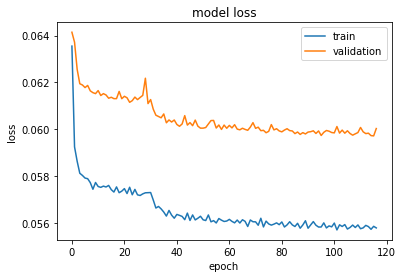

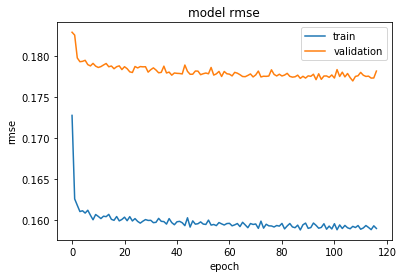

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

## Evaluate performance on validation data to improve model

In [13]:
model.load_weights(experiment_name+'.hdf5')

(6292, 25, 1) (6292, 30)


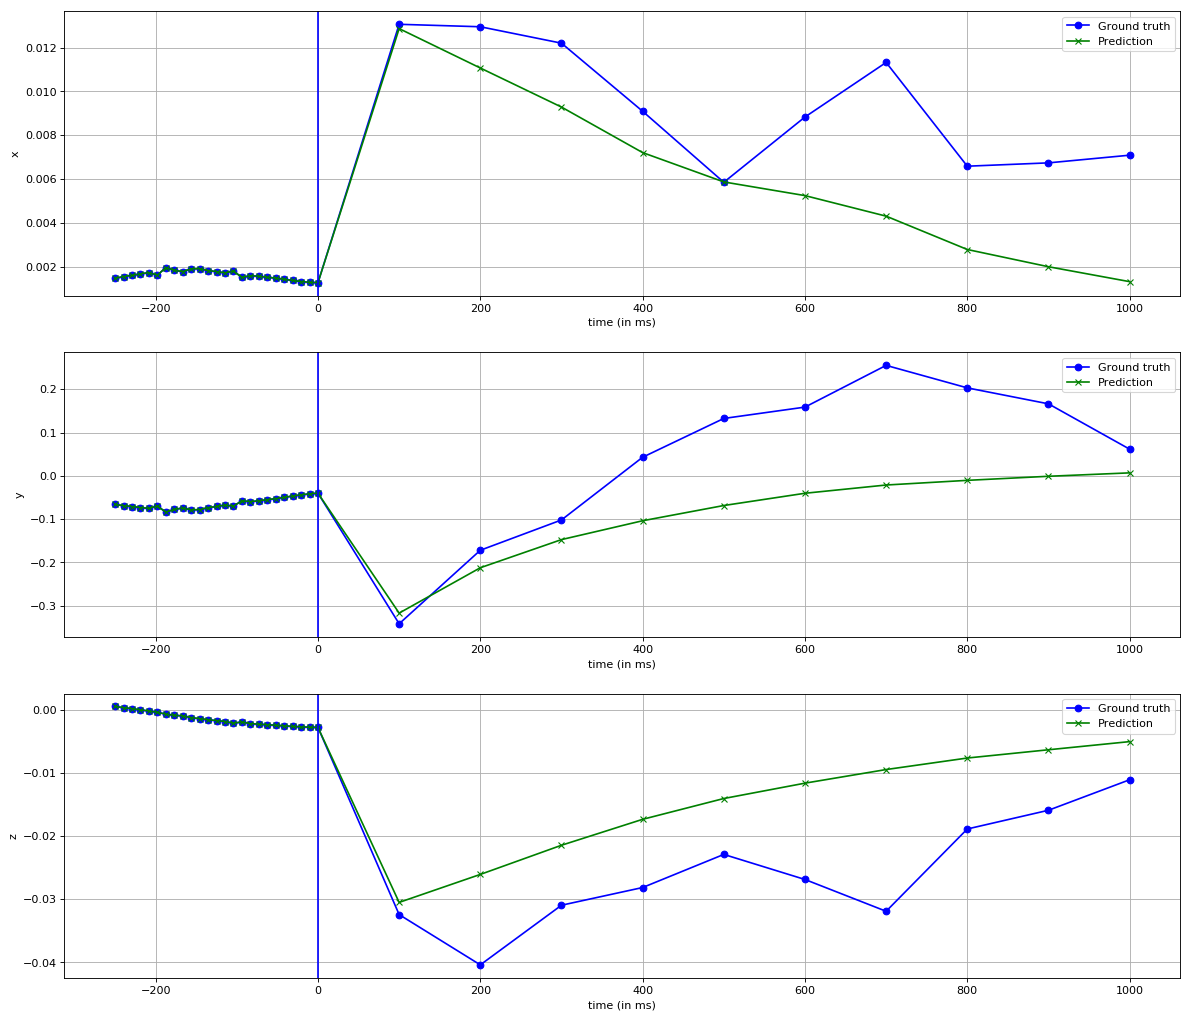

In [14]:
[X_x, X_y, X_z], Y_val = next(val_gen)

print(X_x.shape, Y_val.shape)
Y_pred = model.predict([X_x, X_y, X_z], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)

x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len_delay)))
time_sample = 700+100
plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((X_x[time_sample,:,0], Y_val[time_sample, 0:10])), label="Ground truth", c='b', marker="o")
plt.plot(x_axis_pred, np.concatenate((X_x[time_sample,:,0], Y_pred[time_sample, 0:10])), label="Prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')
plt.grid(True)
plt.axvline(x=0, c="b")


plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((X_y[time_sample,:,0], Y_val[time_sample, 10:20])), label="Ground truth", c='b', marker="o")
plt.plot(x_axis_pred, np.concatenate((X_y[time_sample,:,0], Y_pred[time_sample, 10:20])),label='Prediction', c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')
plt.grid(True)
plt.axvline(x=0, c="b")


plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((X_z[time_sample,:,0], Y_val[time_sample, 20:30])), label="Ground truth", c='b', marker="o")
plt.plot(x_axis_pred, np.concatenate((X_z[time_sample,:,0], Y_pred[time_sample, 20:30])),label='Prediction', c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')
plt.grid(True)
plt.axvline(x=0, c="b")

In [15]:
val_gen_pred = data_generator_head(path_to_sensor_data_train,
                                   file_names_val,
                                   delays_list,
                                   n_max_delay,
                                   n_lookback,
                                   n_delay,
                                   inference=True
                                  )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Evaluating on validation data...")
count = 0
for [X_x, X_y, X_z], Y_val_abs in val_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([X_x, X_y, X_z], verbose=0)
    
    Y_pred_diff_reshaped = np.zeros(shape=(Y_pred_diff.shape[0], len_delay, 3))
    
    Y_pred_diff_reshaped[:, :, 0] = Y_pred_diff[:, 0:10]
    Y_pred_diff_reshaped[:, :, 1] = Y_pred_diff[:, 10:20]
    Y_pred_diff_reshaped[:, :, 2] = Y_pred_diff[:, 20:30]
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff_reshaped.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff_reshaped[:, :i+1], axis=1) * MAX_DIFF
    
    Y_val_abs = Y_val_abs[:, 1:]
    
    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_val = Y_val_abs[:,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating on validation data...
Evaluation Time :  62.47857141494751 s =  1.0413095355033875 min =  0.017355159057511223 h


In [16]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05985896485496871
Delay 100 ms: 0.005079592252524506
Delay 200 ms: 0.013958893190404017
Delay 300 ms: 0.02534636816102633
Delay 400 ms: 0.038032147743005805
Delay 500 ms: 0.05141517865883297
Delay 600 ms: 0.06515507840695724
Delay 700 ms: 0.07908252559376537
Delay 800 ms: 0.0930595637530316
Delay 900 ms: 0.10691147231503785
Delay 1000 ms: 0.12054882847510176

RMSE
Average rmse: 0.12560520413015824
Delay 100 ms: 0.013268292410460424
Delay 200 ms: 0.02951655655540937
Delay 300 ms: 0.050106609798998204
Delay 400 ms: 0.07248975544755426
Delay 500 ms: 0.09555099987152045
Delay 600 ms: 0.11878625594030418
Delay 700 ms: 0.14182652942616833
Delay 800 ms: 0.16445849544641292
Delay 900 ms: 0.18654522325268819
Delay 1000 ms: 0.2079618526321893

SMAPE
Average smape: 14.525052001889705
Delay 100 ms: 2.4573106946771293
Delay 200 ms: 5.621612035414574
Delay 300 ms: 8.68429160507886
Delay 400 ms: 11.519316018875104
Delay 500 ms: 14.1001665844359
Delay 600 ms: 16.474911625315833
Dela

## Evaluate performance on test data

In [17]:
path_to_sensor_data_test = os.path.join(dir_path, "preprocessed_test")
file_names_test = os.listdir(path_to_sensor_data_test)

test_gen_pred = data_generator_head(path_to_sensor_data_test,
                                   file_names_test,
                                   delays_list,
                                   n_max_delay,
                                   n_lookback,
                                   n_delay,
                                   inference=True,
                                  )

predictions_mae_test = np.zeros((len(file_names_test), 1+len_delay))
predictions_rmse_test = np.zeros((len(file_names_test), 1+len_delay))
predictions_smape_test = np.zeros((len(file_names_test), 1+len_delay))
predictions_mfe_test = np.zeros((len(file_names_test), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Evaluating on test data...")
count = 0
for [X_x, X_y, X_z], Y_test_abs in test_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([X_x, X_y, X_z], verbose=0)
    
    Y_pred_diff_reshaped = np.zeros(shape=(Y_pred_diff.shape[0], len_delay, 3))
    
    Y_pred_diff_reshaped[:, :, 0] = Y_pred_diff[:, 0:10]
    Y_pred_diff_reshaped[:, :, 1] = Y_pred_diff[:, 10:20]
    Y_pred_diff_reshaped[:, :, 2] = Y_pred_diff[:, 20:30]
    
    # From normalized differences to absolute testues
    Y_pred = np.zeros(Y_pred_diff_reshaped.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_test_abs[:,0] + np.sum(Y_pred_diff_reshaped[:, :i+1], axis=1) * MAX_DIFF
    
    Y_test_abs = Y_test_abs[:, 1:]
    
    predictions_mae_test[count, 0] = get_mae(Y_pred, Y_test_abs)
    predictions_rmse_test[count, 0] = get_rmse(Y_pred, Y_test_abs)
    predictions_smape_test[count, 0] = get_smape(Y_pred, Y_test_abs)
    predictions_mfe_test[count, 0] = get_mfe(Y_pred, Y_test_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_test = Y_test_abs[:,ind_delay]
        
        predictions_mae_test[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_test)
        predictions_rmse_test[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_test)
        predictions_smape_test[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_test)
        predictions_mfe_test[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_test)
    
    count += 1
    if count == len(file_names_test):
        break

results_mae_test = np.mean(predictions_mae_test, axis=0)
results_rmse_test = np.mean(predictions_rmse_test, axis=0)
results_smape_test = np.mean(predictions_smape_test, axis=0)
results_mfe_test = np.mean(predictions_mfe_test, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating on test data...
Evaluation Time :  70.9737446308136 s =  1.1828957557678224 min =  0.01971492932902442 h


In [18]:
print("MAE")
print("Average mae:", results_mae_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_test[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_test[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_test[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_test[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_test[i+1])

MAE
Average mae: 0.05538553272881021
Delay 100 ms: 0.004726006104272048
Delay 200 ms: 0.013141515011260053
Delay 300 ms: 0.02386157348995803
Delay 400 ms: 0.03568951328800632
Delay 500 ms: 0.04805868944075358
Delay 600 ms: 0.06059854668204186
Delay 700 ms: 0.07321672795714107
Delay 800 ms: 0.08582871596019087
Delay 900 ms: 0.09827647614856652
Delay 1000 ms: 0.11045756320591162

RMSE
Average rmse: 0.11902140749867389
Delay 100 ms: 0.011541600955688344
Delay 200 ms: 0.027264951166650432
Delay 300 ms: 0.047447196380878
Delay 400 ms: 0.06935606954676982
Delay 500 ms: 0.09163945146586583
Delay 600 ms: 0.11367579365682438
Delay 700 ms: 0.13520515399217525
Delay 800 ms: 0.15609164103970716
Delay 900 ms: 0.17627409688323833
Delay 1000 ms: 0.1956445670600988

SMAPE
Average smape: 13.75387849198347
Delay 100 ms: 2.422011412791182
Delay 200 ms: 5.519046731641024
Delay 300 ms: 8.443056480281573
Delay 400 ms: 11.04688301362327
Delay 500 ms: 13.415546683995888
Delay 600 ms: 15.569924315944785
Delay 